In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.data import Data
from torch_geometric.nn import GAE, GCNConv
from tqdm import trange
from utils import evaluate_clustering, get_clusters, plot_training_history, plot_3d_clustering_comparison

# Dual-decoder Graph Autoencoder
From the paper [Dual-decoder graph autoencoder for unsupervised graph representation learning](https://www.sciencedirect.com/science/article/abs/pii/S0950705121008261).

## Loading the data
We use the Cora dataset, a standard benchmark dataset for clustering.

In [2]:
dataset = Planetoid(root='../data/Planetoid', name='Cora')
data = dataset[0]
data.train_mask = data.test_mask = data.val_mask = None
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708])

## Dual-decoder Graph Autoencoder (DGAE) model
The model has a standard GCN encoder and two GCN decoders, one for the adjacency matrix (inner product) and one for the feature matrix (a GCN symmetric to the encoder).

In [3]:
class GCN(nn.Module):
	def __init__(self, in_channels: int, out_channels: int, hidden_dim: int):
		super(GCN, self).__init__()
		self.conv1 = GCNConv(in_channels, hidden_dim)
		self.conv2 = GCNConv(hidden_dim, out_channels)

	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor = None) -> torch.tensor:
		x = F.relu(self.conv1(x, edge_index, edge_weight))
		return self.conv2(x, edge_index, edge_weight)

In [4]:
class DGAE(nn.Module):
	"""
	Dual-encoder Graph Autoencoder model from https://www.sciencedirect.com/science/article/abs/pii/S0950705121008261.
	"""
	def __init__(self, in_channels: int, latent_dim: int):
		super(DGAE, self).__init__()
		self.gae = GAE(GCN(in_channels, latent_dim, latent_dim),)
		self.feat_decoder = GCN(latent_dim, in_channels, latent_dim)
			
	def encode(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor = None) -> torch.tensor:
		"""
		Encodes the input graph into a latent representation.
		:param x: The feature matrix of the graph X (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb) 
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The encoded latent representation of the graph z (Nodes_nb, Hidden_size)
		"""
		return self.gae.encode(x, edge_index, edge_weight)
	
	def decode(self, z: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor = None) -> tuple[torch.tensor, torch.tensor]:
		"""
		Decodes the latent representation into the feature matrix.
		:param z: The encoded latent representation of the graph z (Nodes_nb, Hidden_size)
		:param edge_index: The edge index of the graph A (2, Edges_nb) 
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The decoded adjacency matrix of the graph A (Nodes_nb, Nodes_nb) and the decoded feature matrix of the graph X' (Nodes_nb, Features_nb)
		"""
		return self.gae.decode(z), self.feat_decoder(z, edge_index, edge_weight)
	
	def feat_recon_loss(self, x: torch.tensor, z: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor = None) -> torch.tensor:
		"""
		Calculates the feature matrix reconstruction loss.
		:param x: The original feature matrix of the graph X (Nodes_nb, Features_nb)
		:param z: The encoded latent representation of the graph z (Nodes_nb, Hidden_size)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The feature matrix reconstruction loss
		"""
		return F.mse_loss(self.feat_decoder(z, edge_index, edge_weight), x)
	
	def loss(self, x: torch.tensor, z: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor = None, lam: float = .5) -> torch.tensor:
		"""
		Calculates the loss of the DGAE model.
		:param x: The original feature matrix of the graph X (Nodes_nb, Features_nb)
		:param z: The encoded latent representation of the graph z (Nodes_nb, Hidden_size)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:param lam: The lambda parameter for feature matrix loss
		:return: The loss of the DGAE model
		"""
		return self.gae.recon_loss(z, edge_index) + lam / 2 * self.feat_recon_loss(x, z, edge_index, edge_weight)
	
	def forward(self, x: torch.tensor, edge_index: torch.tensor, edge_weight: torch.tensor = None) -> tuple[torch.tensor, torch.tensor]:
		"""
		Performs a forward pass on the DGAE model.
		:param x: The feature matrix of the graph X (Nodes_nb, Features_nb)
		:param edge_index: The edge index of the graph A (2, Edges_nb)
		:param edge_weight: The edge weight of the graph (Edges_nb,)
		:return: The decoded adjacency matrix of the graph A (Nodes_nb, Nodes_nb) and the decoded feature matrix of the graph X' (Nodes_nb, Features_nb)
		"""
		z = self.encode(x, edge_index, edge_weight)
		return self.decode(z, edge_index, edge_weight)

## Instantiating and training the models
The DGAE model is instantiated and trained with the loss function specified in the paper, which uses the reconstruction loss of the adjacency matrix and of the feature matrix.

In [5]:
def train_model(model: nn.Module, data: Data, optimizer: optim.Optimizer, num_epochs: int = 200, tqdm_desc: str = "Epochs", n_tries: int = 5) -> np.ndarray:
	metrics = np.zeros((num_epochs, 5))
	for epoch in (pbar := trange(num_epochs, desc=tqdm_desc)):
		optimizer.zero_grad()
		z = model.encode(data.x, data.edge_index)
		loss = model.loss(data.x, z, data.edge_index)
		loss.backward()
		optimizer.step()
		z_np = z.detach().numpy()
		clusters = [get_clusters(z_np, n_clusters) for _ in range(n_tries)]  # the score can depend on the initial cluster assignment, so we try multiple times
		accuracy, nmi, ari, silouhette = evaluate_clustering(z_np, data.y, max(clusters, key=lambda c: evaluate_clustering(z_np, data.y, c)[0]))
		metrics[epoch] = np.array([loss.item(), accuracy, nmi, ari, silouhette])
		pbar.set_postfix({"Loss": loss.item(), "Accuracy": accuracy, "NMI": nmi, "ARI": ari, "Silouhette": silouhette})
	return metrics

In [6]:
latent_dim, num_epochs, lr, n_clusters = 32, 200, .0005, len(np.unique(data.y.numpy()))

dgae = DGAE(data.num_features, latent_dim)
optimizer = optim.Adam(dgae.parameters(), lr=lr)

In [7]:
training = train_model(dgae, data, optimizer, num_epochs, "DGAE")
history_labels = ['Loss', 'Accuracy', 'NMI Score', 'ARI Score', 'Silouhette Score']

DGAE: 100%|██████████| 200/200 [06:00<00:00,  1.80s/it, Loss=0.854, Accuracy=0.688, NMI=0.497, ARI=0.433, Silouhette=0.234]


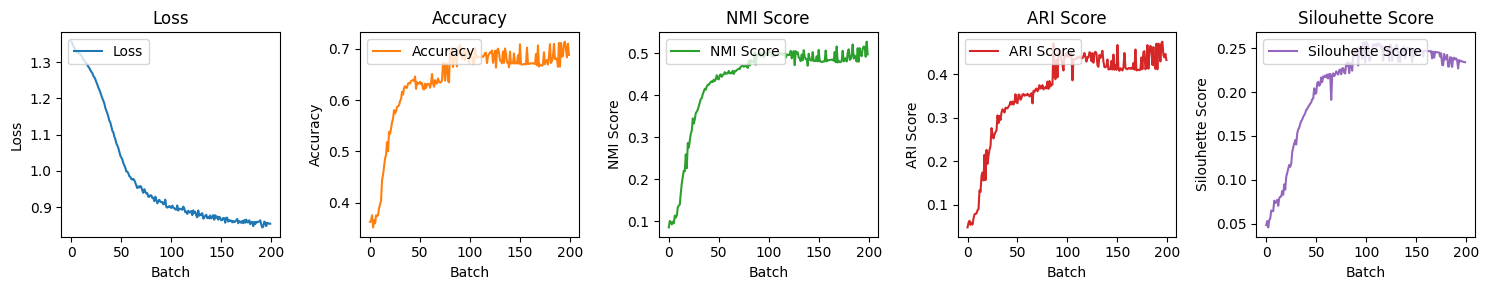

In [8]:
plot_training_history(history_labels, training, "DGAE Training")

In [12]:
z_np = dgae.encode(data.x, data.edge_index).detach().numpy()

n_tries = 5
clusters = [get_clusters(z_np, n_clusters) for _ in range(n_tries)]
best_clusters = max(clusters, key=lambda c: evaluate_clustering(z_np, data.y, c)[0])

accuracy, nmi, ari, silouhette = evaluate_clustering(z_np, data.y, best_clusters)
print(f"Accuracy: {accuracy:.4f}, NMI: {nmi:.4f}, ARI: {ari:.4f}, Silouhette: {silouhette:.4f}")

Accuracy: 0.7190, NMI: 0.5226, ARI: 0.4854, Silouhette: 0.2348


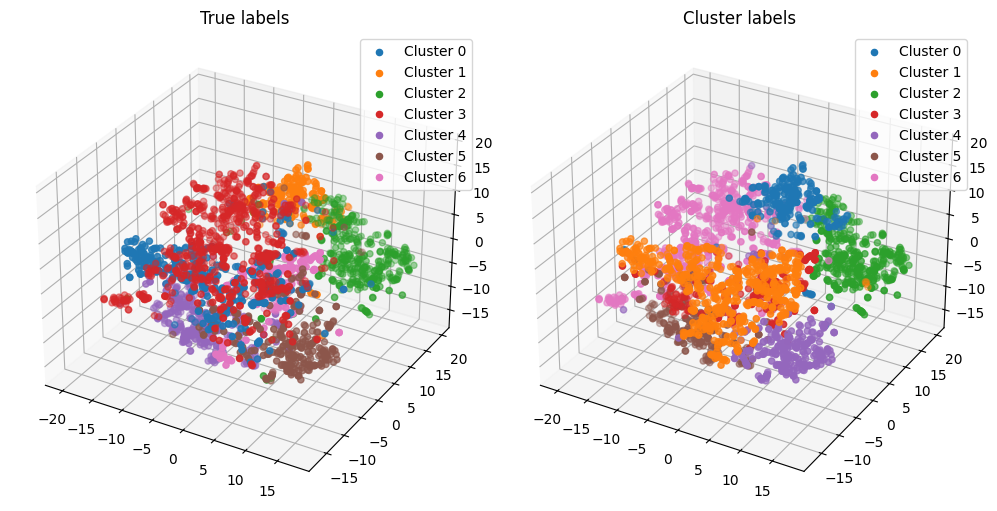

In [13]:
plot_3d_clustering_comparison(z_np, data.y, best_clusters, n_clusters)